# The Cookbook of Neural ODEs

Torchdyn implements out-of-the-box a variety of continuous-depth models. In this introductory tutorial, we show how we can flexibly switch to one model to another with minor efforts. We will touch the following neural ODE variants:

* **Vanilla** (depth-invariant) (same as the [torchdyn quickstart](./00_quickstart.html) tutorial)
* **Vanilla** (depth-variant)
* **Galerkin**
* **Data-controlled**
* **Stable** (WiP)

--------------------------------------

For more advanced models check out 

* [Hamiltonian Neural Networks](./06_hamiltonian_nn.html)
* [Graph Neural ODEs](./07_graph_neural_de.html)
* **Lagrangian Neural Networks** (WiP)
* **Continuous Normalizing Flows** (WiP)
* **ODE-RNN** (WiP)

In [1]:
from torchdyn.models import *; from torchdyn.data_utils import *
from torchdyn import *

**Data:** we use again the moons dataset (with some added noise) simply because all the models will be effective to solve the binary classification problem.



In [2]:
d = ToyDataset()
X, yn = d.generate(n_samples=512, dataset_type='moons', noise=.4)

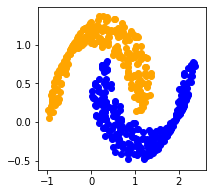

In [3]:
import matplotlib.pyplot as plt

colors = ['orange', 'blue'] 
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
for i in range(len(X)):
    ax.scatter(X[i,0], X[i,1], color=colors[yn[i].int()])

In [4]:
import torch
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn.long()).to(device)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=len(X), shuffle=False)

**Learner**

In [5]:
import torch.nn as nn
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module, settings:dict={}):
        super().__init__()
        defaults.update(settings)
        self.settings = defaults
        self.model = model
        self.c = 0
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch      
        y_hat = self.model(x)   
        loss = nn.CrossEntropyLoss()(y_hat, y)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.005)

    def train_dataloader(self):
        return trainloader

**Note:** In this notebook we will consider the depth domain $[0,1]$, i.e. $s\in[0,1]$. Note that, for most architectures in *static* settings (aka we do not deal with dynamic data) any other depth domain do not actually afftect the absolute expressiveness of neural ODE is it can be seen as a rescaled/shifted version of $[0,1]$. Please note that, however, other choices of the depth domain can indeed affect the training phase

It can be accessed and modified through the `s_span` setting of `NeuralDE` class

## Vanilla Neural ODE (Depth-Invariant)

$$ \left\{
    \begin{aligned}
        \dot{h}(s) &= f(h(s), \theta)\\
        h(0) &= x\\
        \hat y & = h(1)
    \end{aligned}
    \right. \quad s\in[0,1]
$$

This model is the same used in [torchdyn quickstart](./00_quickstart.html) tutorial. The vector field is parametrized by a neural network $f$ with *static* parameters $\theta$ and taking as input only the state $h(s)$.

In [6]:
# model settings
settings = {'type':'classic', 'controlled':False, 'solver':'dopri5'}

# vector field parametrized by a NN
f = DEFunc(nn.Sequential(
        nn.Linear(2, 64),
        nn.Tanh(), 
        nn.Linear(64, 2)))

# neural ODE
model = NeuralDE(f, settings).to(device)

In [7]:
# train the neural ODE
learn = Learner(model)
trainer = pl.Trainer(min_nb_epochs=300, max_nb_epochs=600)
trainer.fit(learn)

INFO:lightning:
  | Name             | Type       | Params
--------------------------------------------
0 | model            | NeuralDE   | 322   
1 | model.defunc     | DEFunc     | 322   
2 | model.defunc.m   | Sequential | 322   
3 | model.defunc.m.0 | Linear     | 192   
4 | model.defunc.m.1 | Tanh       | 0     
5 | model.defunc.m.2 | Linear     | 130   
6 | model.adjoint    | Adjoint    | 0     


C:\Users\stefano\Anaconda3\lib\site-packages\pytorch_lightning\utilities\warnings.py:18: RuntimeWarning: Displayed epoch numbers in the progress bar start from "1" until v0.6.x, but will start from "0" in v0.8.0.
  warnings.warn(*args, **kwargs)


1

**Plots**

In [8]:
# Evaluate the data trajectories
s_span = torch.linspace(0,1,100)
trajectory = model.trajectory(X_train, s_span).detach().cpu()

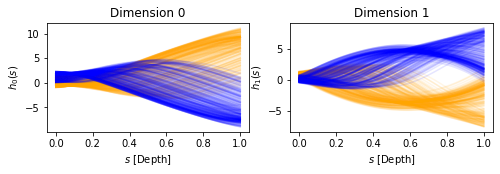

In [9]:
# Trajectories in the depth domain
plot_2D_depth_trajectory(s_span, trajectory, yn, len(X))

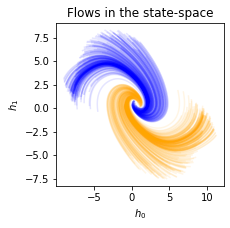

In [10]:
# Trajectories in the state-space
plot_2D_state_space(trajectory, yn, len(X),)

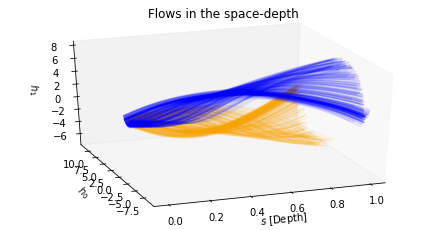

In [11]:
# Trajectories in space-depth
plot_2D_space_depth(s_span, trajectory, yn, len(X))

## Vanilla Neural ODE (Depth-Variant)

$$ \left\{
    \begin{aligned}
        \dot{h}(s) &= f(s, h(s), \theta)\\
        h(0) &= x\\
        \hat y & = h(1)
    \end{aligned}
    \right. \quad s\in[0,1]
$$

This model, contemplated by the seminal paper from [[Chen T. Q. et al, 2018]](https://arxiv.org/abs/1806.07366), is usually obtained by concatenating $s$ to the state $h$ as input of $f$, i.e. $f([h(s),s])$. For a simple and flexible implementation we developed the class `DepthCat`, which takes care automatically of concatenating $s$ to the state at each call of the `DEFunc`. The final user only needs specify to which dimension $s$ should be appended. Specifically, for an MLP, $h\in\mathbb{R}^{batch\times dims}$ and, thus we should use `DepthCat(1)`.

In [12]:
# model settings
settings = {'type':'classic', 'controlled':False, 'solver':'dopri5'}

# vector field parametrized by a NN
f = DEFunc(nn.Sequential(
        DepthCat(1),
        nn.Linear(3, 64),
        nn.Tanh(),
        DepthCat(1),
        nn.Linear(65, 2)))
# neural ODE
model = NeuralDE(f, settings).to(device)

In [13]:
# train the neural ODE
learn = Learner(model)
trainer = pl.Trainer(min_nb_epochs=300, max_nb_epochs=600)
trainer.fit(learn)

INFO:lightning:
  | Name             | Type       | Params
--------------------------------------------
0 | model            | NeuralDE   | 388   
1 | model.defunc     | DEFunc     | 388   
2 | model.defunc.m   | Sequential | 388   
3 | model.defunc.m.0 | DepthCat   | 0     
4 | model.defunc.m.1 | Linear     | 256   
5 | model.defunc.m.2 | Tanh       | 0     
6 | model.defunc.m.3 | DepthCat   | 0     
7 | model.defunc.m.4 | Linear     | 132   
8 | model.adjoint    | Adjoint    | 0     


C:\Users\stefano\Anaconda3\lib\site-packages\pytorch_lightning\utilities\warnings.py:18: RuntimeWarning: Displayed epoch numbers in the progress bar start from "1" until v0.6.x, but will start from "0" in v0.8.0.
  warnings.warn(*args, **kwargs)


1

**Plot**

In [14]:
# Evaluate the data trajectories
s_span = torch.linspace(0,1,100)
trajectory = model.trajectory(X_train, s_span).detach().cpu()

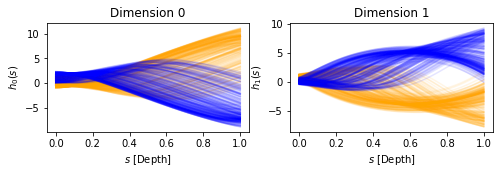

In [15]:
# Trajectories in the depth domain
plot_2D_depth_trajectory(s_span, trajectory, yn, len(X))

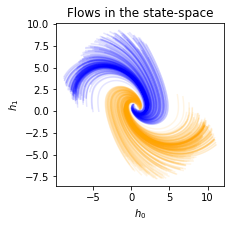

In [16]:
# Trajectories in the state-space
plot_2D_state_space(trajectory, yn, len(X),)

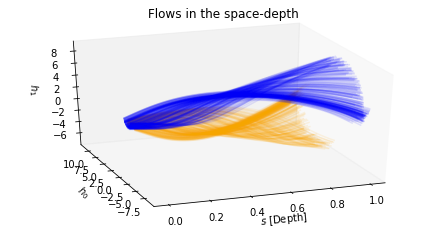

In [17]:
# Trajectories in space-depth
plot_2D_space_depth(s_span, trajectory, yn, len(X))

## Galerkin-Style Neural ODE

Galerkin-style neural ODEs proposed in [Massaroli S., Poli M. et al., 2020](https://arxiv.org/abs/2002.08071) make the weights of the neural ODE to be *depth-varying*, i.e. $\theta=\theta(s)$ obtaining a model of type

$$
    \left\{
    \begin{aligned}
        \dot{h}(s) &= f(h(s), \theta(s))\\
        h(0) &= x\\
        \hat y & = h(1)
    \end{aligned}
    \right. \quad s\in[0,1]
$$

where the depth evolution of $\theta(s)$ is parametrized by a trucated eigenfunction expasion, usually an orthogonal basis of some functional space, i.e.

$$
    \forall i \quad \theta_i(s) = \sum_{j=0}^{m}\gamma_j\odot\psi_j(s)
$$

The model is then trained by optimizing for the eigenvalues $\gamma_j$. Note that if $\theta\in \mathbb{R}^d$ there will be $d\times m$ final model's parameters. In this tutorial, we use a 10th-order polynomial expansion to model $\theta(s)$.

**Note:** In `torchdyn 0.1.0` only Fourier `FourierExpansion` and polynomial `PolyExpansion` bases are currently implemented out of the box. Although we planned to add further bases, e.g.  piece-wise constant functions, radial basis functions, etc., users could create custom `Expansions` by their own. A tutorial notebook will be soon released

In [18]:
# model settings (same as previous models)
settings = {'type':'classic', 'controlled':False, 'solver':'dopri5'}

# vector field parametrized by a NN with "GalLinear" layer
f = DEFunc(nn.Sequential(
            DepthCat(1),
            GalLinear(2, 32, expfunc=PolyExpansion, 
                      n_harmonics=10, n_eig=1),
            nn.Tanh(),
            nn.Linear(32,2)))
# neural ODE
model = NeuralDE(f, settings).to(device)

In [19]:
# train the neural ODE
learn = Learner(model)
trainer = pl.Trainer(min_nb_epochs=300, max_nb_epochs=600)
trainer.fit(learn)

INFO:lightning:
  | Name             | Type       | Params
--------------------------------------------
0 | model            | NeuralDE   | 1 K   
1 | model.defunc     | DEFunc     | 1 K   
2 | model.defunc.m   | Sequential | 1 K   
3 | model.defunc.m.0 | DepthCat   | 0     
4 | model.defunc.m.1 | GalLinear  | 960   
5 | model.defunc.m.2 | Tanh       | 0     
6 | model.defunc.m.3 | Linear     | 66    
7 | model.adjoint    | Adjoint    | 0     


C:\Users\stefano\Anaconda3\lib\site-packages\pytorch_lightning\utilities\warnings.py:18: RuntimeWarning: Displayed epoch numbers in the progress bar start from "1" until v0.6.x, but will start from "0" in v0.8.0.
  warnings.warn(*args, **kwargs)


1

**Plot**

In [20]:
# Evaluate the data trajectories
s_span = torch.linspace(0,1,100)
trajectory = model.trajectory(X_train, s_span).detach().cpu()

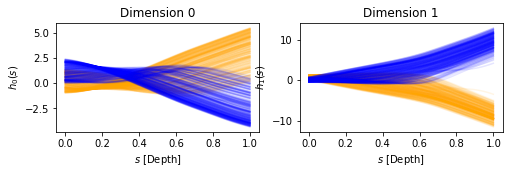

In [21]:
# Trajectories in the depth domain
plot_2D_depth_trajectory(s_span, trajectory, yn, len(X))

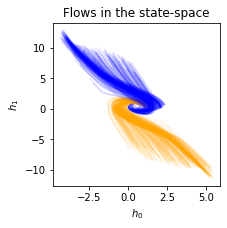

In [22]:
# Trajectories in the state-space
plot_2D_state_space(trajectory, yn, len(X),)

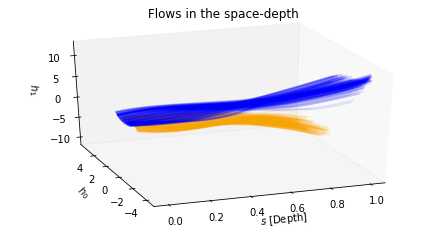

In [23]:
# Trajectories in space-depth
plot_2D_space_depth(s_span, trajectory, yn, len(X))

## Data-Controlled Neural ODE

Data-controlled neural ODEs, also introduced in [Massaroli S., Poli M. et al., 2020](https://arxiv.org/abs/2002.08071) consist in feeding to the vector field the input data $x$ (the initial condition of the ODE), leading to

$$ \left\{
    \begin{aligned}
        \dot{h}(s) &= f(h(s), x, \theta)\\
        h(0) &= x\\
        \hat y & = h(1)
    \end{aligned}
    \right. \quad s\in[0,1]
$$

In this way, the neural ODE learns a family of vector fields rather than a single one. 

In practice, we simply concatenate $x$ to $h$ and simply feed $[h, x]$ to $f$, which should indeed be defined to accomodate the extra $dim(x)$ dimensions. Data-controlled neural ODEs type can be implemented by simply setting `controlled=True`

In [24]:
# model settings - here we set 'controlled' to True
settings = {'type':'classic', 'controlled':True, 'solver':'dopri5'}

# vector field parametrized by a NN which takes as input [h, x]
f = DEFunc(nn.Sequential(
        nn.Linear(4, 64),
        nn.Tanh(),
        nn.Linear(64,2)))

# neural ODE
model = NeuralDE(f, settings).to(device)

In [25]:
learn = Learner(model)
trainer = pl.Trainer(min_nb_epochs=300, max_nb_epochs=600)
trainer.fit(learn)

INFO:lightning:
  | Name             | Type       | Params
--------------------------------------------
0 | model            | NeuralDE   | 450   
1 | model.defunc     | DEFunc     | 450   
2 | model.defunc.m   | Sequential | 450   
3 | model.defunc.m.0 | Linear     | 320   
4 | model.defunc.m.1 | Tanh       | 0     
5 | model.defunc.m.2 | Linear     | 130   
6 | model.adjoint    | Adjoint    | 0     


C:\Users\stefano\Anaconda3\lib\site-packages\pytorch_lightning\utilities\warnings.py:18: RuntimeWarning: Displayed epoch numbers in the progress bar start from "1" until v0.6.x, but will start from "0" in v0.8.0.
  warnings.warn(*args, **kwargs)


1

**Plots**

In [26]:
# Evaluate the data trajectories
s_span = torch.linspace(0,1,100)
trajectory = model.trajectory(X_train, s_span).detach().cpu()

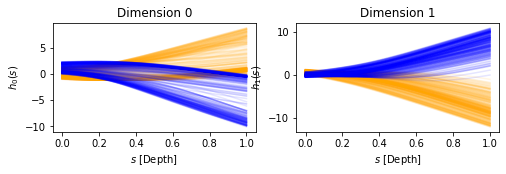

In [27]:
# Trajectories in the depth domain
plot_2D_depth_trajectory(s_span, trajectory, yn, len(X))

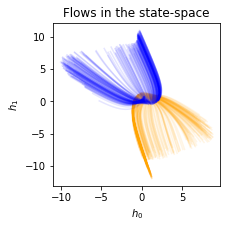

In [28]:
# Trajectories in the state-space
plot_2D_state_space(trajectory, yn, len(X),)

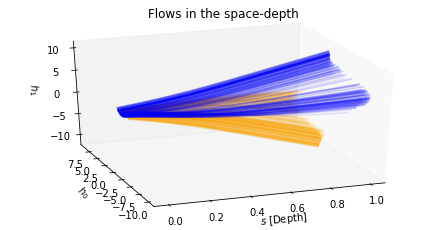

In [29]:
# Trajectories in space-depth
plot_2D_space_depth(s_span, trajectory, yn, len(X))